# GloVe Example

## Download GloVe Embeddings

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-22 21:44:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-22 21:44:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-22 21:44:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import train_test_split, cross_val_score

from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re   
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [164]:
def normalize_review(review):
    #normalize data
    # Remove hashtags
    res = re.sub(r'(#)(#)*(\w)*', '', review)
    # Remove all punctuations and special characters
    res = re.sub(r'[^\w\s]', '', res)
    return res
def lemmatization(review):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets_tokenized = []
    review_words = []
    word_tokens = word_tokenize(review)
    for word in word_tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        review_words.append(lemmatized_word)

    res =  (' '.join([str(elem) for elem in review_words]).lower())
    return res

False


Please enter your Test Dataframe Here



In [226]:
my_test= None    # Please enter your dataframe here like this my_test = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
if(not (my_test is  None)):
    my_test = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
    my_test['review'] = my_test['review'].apply(normalize_review)
    my_test['review'] = my_test['review'].apply(lemmatization)
    my_test.loc[my_test['rating'] <=4 , 'rating'] = 0   #if your dataframe already has ratings in binary form please comment out these two lines 
    my_test.loc[my_test['rating'] >= 7, 'rating'] = 1


  


In [227]:
    df1 = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
    df1['review'] = df1['review'].apply(normalize_review)
    df1['review'] = df1['review'].apply(lemmatization)
    df1.loc[df1['rating'] <=4 , 'rating'] = 0
    df1.loc[df1['rating'] >= 7, 'rating'] = 1


## Transform GloVe embeddings to Word2Vec format

In [191]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = '/content/drive/MyDrive/AI2/glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [192]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [228]:

#creating w2v
review_vector=[]
for review in df1["review"]:
  k=0.0
  rev_vector=0
  for word in review.split():
    if word in model.vocab:
      k+=1.0
      rev_vector+=model[word]
  if(k!=0.0):
    rev_vector/=k #dividing the sum of the words by k (the words from the review wich exist in the model's vocab)
    review_vector.append(rev_vector)
  else:
    rev_vector=[0]*model.vector_size #initializing an array of 0 in case no word of the  model appears in review
    review_vector.append(rev_vector)

print(len(review_vector))

      

45008


In [230]:
revs=review_vector
rt=df1[["rating"]]

if my_test is None:
  x_train, x_test, y_train, y_test = train_test_split(revs, rt, test_size=0.2)
else:
    x_train=revs
    y_train=rt
    y_test=my_test["rating"]
    review_test_vector=[]
    for review in my_test["review"]: #converting your data to w2v as well
      k=0.0
      rev_vector=0
      for word in review.split():
        if word in model.vocab:
          k+=1.0
          rev_vector+=model[word]
      if(k!=0.0):
        rev_vector/=k
        review_test_vector.append(rev_vector)
      else:
        rev_vector=[0]*model.vector_size
        review_test_vector.append(rev_vector)
    x_test= review_test_vector
    print(len(x_test))





In [231]:
y_train=np.array(y_train)
x = torch.tensor(x_train,dtype=torch.float)
y = torch.tensor(y_train,dtype=torch.float)

## Create a Neural Network

In [234]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        out = self.linear4(h3)
        return out

In [283]:
#Define layer sizes
print(x.shape[1])
D_in = x.shape[1]
H1 = 200
H2 =100
H3 =50
D_out = 1 

#Define Hyperparameters
learning_rate = 1e-4
#Initialise model, loss, optimizer
nmodel = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss(reduction='sum') 
optimizer = torch.optim.SGD(nmodel.parameters(), lr=learning_rate)

#Initialise dataloader
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True) # batch size


300


## Train Network

In [284]:
eps=1e-4
for epoch in range(100):
  batch_losses = 0
  for x_batch, y_batch in dataloader:
    y_pred = nmodel(x_batch)
    loss = loss_func(y_pred, y_batch)
    if loss.isnan(): res=eps
    else: res = loss.item()
    batch_losses+=res
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch:3}: Loss = {batch_losses/len(dataloader):.10f}")
    

Epoch   0: Loss = 16.5790004629
Epoch   1: Loss = 15.8394684580
Epoch   2: Loss = 15.6708837817
Epoch   3: Loss = 15.4382181066
Epoch   4: Loss = 15.0880575637
Epoch   5: Loss = 14.5368419786
Epoch   6: Loss = 13.7326016333
Epoch   7: Loss = 12.7567456196
Epoch   8: Loss = 11.7743859554
Epoch   9: Loss = 10.9016077819
Epoch  10: Loss = 10.2668990759
Epoch  11: Loss = 9.9145398640
Epoch  12: Loss = 9.7057873487
Epoch  13: Loss = 9.5368087398
Epoch  14: Loss = 9.4459962023
Epoch  15: Loss = 9.3550530750
Epoch  16: Loss = 9.2283211822
Epoch  17: Loss = 9.2302185858
Epoch  18: Loss = 9.1882607264
Epoch  19: Loss = 9.1341350108
Epoch  20: Loss = 9.1014475263
Epoch  21: Loss = 9.0649482658
Epoch  22: Loss = 9.0033020855
Epoch  23: Loss = 9.0299868457
Epoch  24: Loss = 8.9914539610
Epoch  25: Loss = 8.9964373277
Epoch  26: Loss = 8.9464721620
Epoch  27: Loss = 8.9238833805
Epoch  28: Loss = 8.9312992740
Epoch  29: Loss = 8.9166910797
Epoch  30: Loss = 8.9312656362
Epoch  31: Loss = 8.87648878

In [286]:
import math
import sklearn.metrics

def convert_to_binary(lst):
  for item in lst:
    item[0]=item[0]
    if(item[0]>=0.5):
      item[0]=1
    else:
      item[0]=0

#calculate the needed scores with sklern.metrics
predictions_val = nmodel(torch.tensor(x_test,dtype=torch.float))
predictions_val_train = nmodel(torch.tensor(x_train,dtype=torch.float))
prlist=predictions_val.tolist()
prlist_train=predictions_val_train.tolist()
convert_to_binary(prlist)
convert_to_binary(prlist_train)
precision_score =sklearn.metrics.precision_score(y_test,prlist)
precision_score_train =sklearn.metrics.precision_score(y_train,prlist_train)
recall_score=sklearn.metrics.recall_score(y_test,prlist)
recall_score_train=sklearn.metrics.recall_score(y_train,prlist_train)
f_measure=sklearn.metrics.f1_score(y_test,prlist)
f_measure_train=sklearn.metrics.f1_score(y_train,prlist_train)
print("Recall  (Test Set) :",recall_score)
print("Recall  (Train Set) :",recall_score_train)
print("Precision (Test Set) :",precision_score)
print("Precision (Train Set) :",precision_score_train)
print("F measure (Test Set) :",f_measure)
print("F measure (Train Set) :",f_measure_train)




Recall  (Test Set) : 0.8445780449788466
Recall  (Train Set) : 0.8516956208025753
Precision (Test Set) : 0.826721883173496
Precision (Train Set) : 0.835374816266536
F measure (Test Set) : 0.8355545764952087
F measure (Train Set) : 0.8434562743912494


Train Data size: 36006
Test Data size: 9002


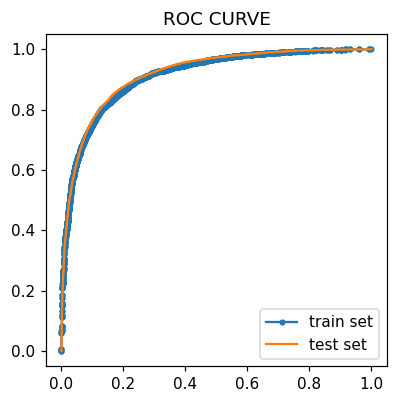

In [241]:
#Printing ROC curves of test and train data with sklearn Roc_curve function
train_crv=nmodel(torch.tensor(x_train,dtype=torch.float)).detach().numpy()
x1,y1,t1=sklearn.metrics.roc_curve(y_test,predictions_val.detach().numpy() )
x2,y2,t2=sklearn.metrics.roc_curve(y_train, train_crv)
print("Train Data size:",len(train_crv))
print("Test Data size:",len(prlist))
plt.figure(figsize=(4, 4), dpi=110)
plt.plot(x1,y1, marker='.', label="train set")
plt.plot(x2,y2,linestyle='-', label="test set")
plt.legend(loc='lower right')
plt.title("ROC CURVE")
plt.show()